# Model Training: 
### Part 1 >>> Predictions at the beginning of the race, no data given during the race is used.

Here we see how close we can predict a race outcome with just data from the Ergast API



In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.giphy.com/media/v1.Y2lkPTc5MGI3NjExajJ0cHhpdnV3NmhpcThscjJ6c3lmd2xvdTVibHluY3hxMDhzZ3lxdiZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/SXxMF5CMWWKZUkBBgJ/giphy.gif")

### 1) Importing Packages and Data

In [3]:
import pandas as pd
import numpy as np
import F1_Preprocessing #Internal package to preprocess data
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(1994)

In [4]:
#The data stored in this path is obtained from the API of https://ergast.com/mrd/. It is continuously updated.
#To update this data please run the file "1_API_Requests_Ergast.py"

path = 'C:/Users/gabri/Dropbox/Gaby/Proyectos/My_Portafolio/F1/Data/'

ResultsDF=pd.read_csv(path+"ResultsDF.csv")

### 2) Data Preprocessing

In [5]:
# Apply the data preprocessing for each df using a function stored in the repo from F1_Preprocessing.py 
# This is done this way so the preprocessing is consistent throughout all notebooks.
# With this code we:
#   - create new features
#   - format dates and floats
#   - encode features

ResultsDF=F1_Preprocessing.preprocess_F1results(ResultsDF,OneHotEncoder=True)

In [6]:
# Group features for further analysis:

selected_features_circuit_focused=['final_position']+ResultsDF.loc[:, ResultsDF.columns.str.startswith("circuit.circuitid_")].columns.to_list()
selected_features_constructor_focused=['final_position']+ResultsDF.loc[:, ResultsDF.columns.str.startswith("constructor.constructorid_")].columns.to_list()
selected_features_driver_focused=['final_position']+ResultsDF.loc[:, ResultsDF.columns.str.startswith("driverid_")].columns.to_list()
selected_features_status_focused=['final_position']+ResultsDF.loc[:, ResultsDF.columns.str.startswith("final_status_grouped_")].columns.to_list()
selected_features_general=['final_position']+[col for col in ResultsDF.columns if col not in selected_features_circuit_focused+
                           selected_features_constructor_focused+selected_features_driver_focused+selected_features_status_focused]

# Not all the features in these dataframe are available before hand. 
# Below we remove features we don't know before the race starts and 
# add features to each observation to have a view of what happened the races before to the same driver
features_to_add_from_the_past=['driverid','season','round',"season-round-driverid","season-round",
                               'final_position', 'final_points', 'final_grid', 'final_laps',
                                'race_time.millis','fastestlap.rank', 'fastestlap.lap', 'fastestlap.averagespeed.speed',
                                'date', 'fastestlap.time.in_milliseconds','race_time_millis_max_round_season', 'race_time_millis_min_round_season',
                                'race_time_millis_avg_round_season', 'race_time_millis_to_max', 'race_time_millis_to_min', 'race_time_millis_to_avg']
features_to_add_from_the_past+=selected_features_circuit_focused+selected_features_constructor_focused+selected_features_status_focused
len(features_to_add_from_the_past)


107

In [8]:
# Add certain features to see how the dirver performed in previous races
ResultsDF2=F1_Preprocessing.get_past_rows(DF=ResultsDF,
                                          N=3,
                                          iterator_feature='driverid',
                                          grouper_feature='season-round',
                                          features_added=features_to_add_from_the_past)

In [33]:
print(ResultsDF2[ResultsDF2["race_time.millis"].isna()]["final_status_grouped"].unique())

['Mechanical Issues' '+Laps' 'Accident']


In [26]:
print(ResultsDF2.isnull().sum().to_frame()[:50])

                                    0
driver_number                       0
final_position                      0
final_positionText                  0
final_points                        0
final_grid                          0
final_laps                          0
driver.permanentnumber              0
driver.code                         0
driver.givenname                    0
driver.familyname                   0
driver.dateofbirth                  0
driver.nationality                  0
constructor.url                     0
constructor.name                    0
constructor.nationality             0
race_time.millis                   73
race_time.time                     73
fastestlap.rank                    13
fastestlap.lap                     13
fastestlap.time.time               13
fastestlap.averagespeed.units      13
fastestlap.averagespeed.speed      13
season                              0
round                               0
racename                            0
circuit.circ

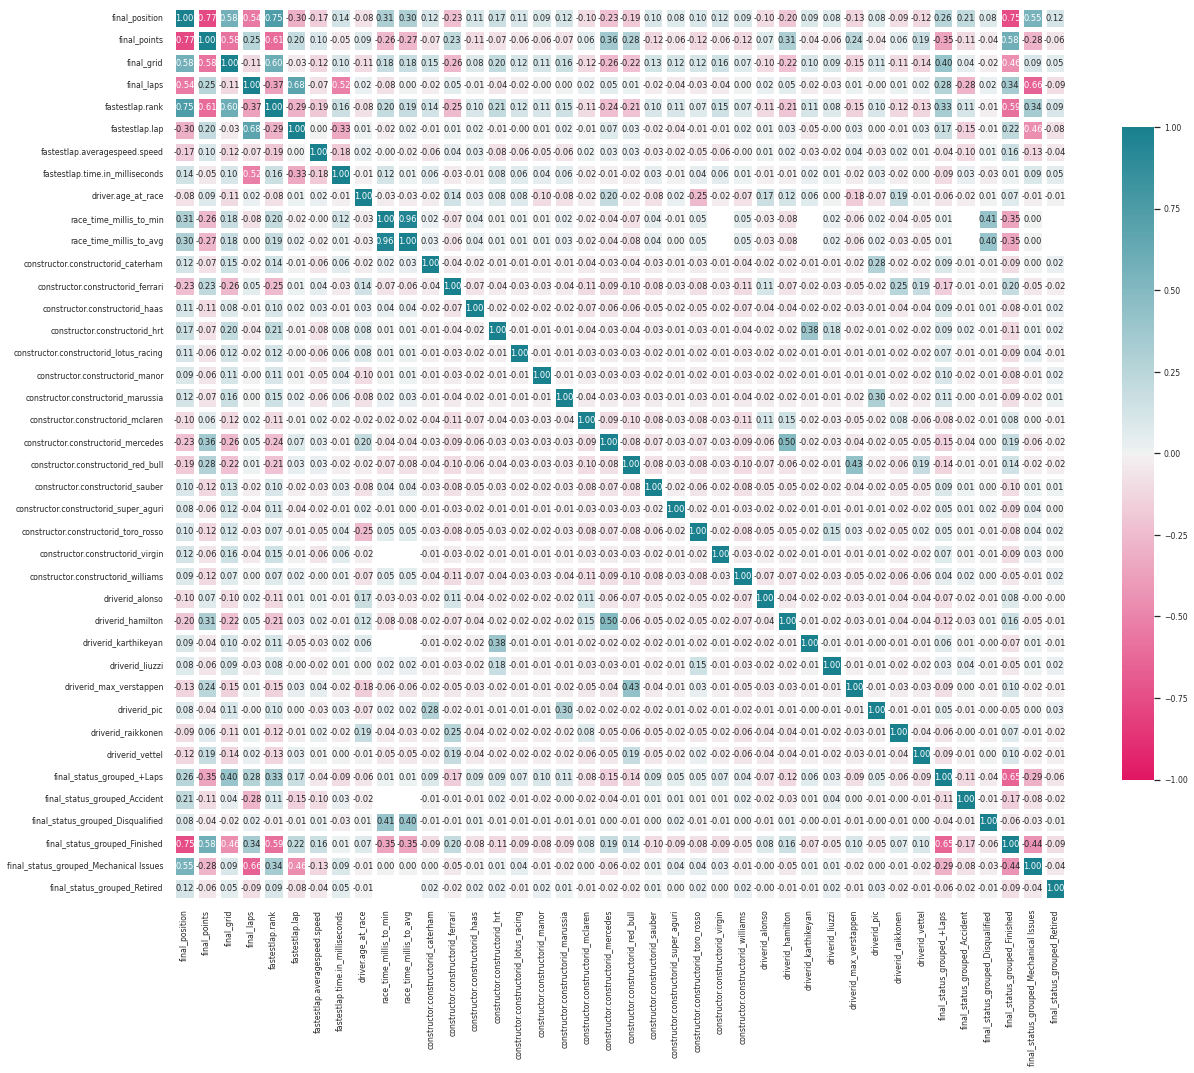

In [5]:

#Create and filter correlation df by absolute correlation value
corr_chosen=0.075
df_corr=ResultsDF[ResultsDF.columns].corr()
high_corr_var=df_corr[(df_corr["final_position"].abs() > corr_chosen)].index
filtered_corr=df_corr.loc[high_corr_var,high_corr_var]

#Plot df
sns.set_theme(style="whitegrid", palette="magma",font_scale=0.7,font="DejaVu Sans")
fig, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(0, 210, 95, 49, as_cmap=True)
sns.heatmap(filtered_corr, annot=True, fmt=".2f", 
           linewidths=5,cmap=cmap, vmin=-1, vmax=1, 
           cbar_kws={"shrink": .6}, square=True)

plt.show()